In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from z3 import *
import time

### load from file

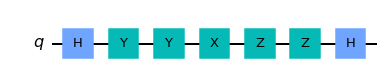

In [2]:
circ0 = QuantumCircuit().from_qasm_file('test.qasm')
circ0.draw('mpl')

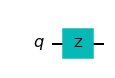

In [3]:
circ1 = QuantumCircuit().from_qasm_file('test1.qasm')
circ1.draw('mpl')

### Some basic functions (maybe useless)

In [4]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def reshape(U):
    if U.shape==(2,2):
        return U
    
    if U.shape[0]==U.shape[1]:
        split_U=np.split(U,2,1)
    else:
        split_U=np.split(U,2,0)
    split_U[0]=reshape(split_U[0])
    split_U[1]=reshape(split_U[1]) 
    return np.array([split_U])[0]            
            
def get_real_qubit_num(cir):
    """Calculate the real number of qubits of a circuit"""
    gates=cir.data
    q=0
    for k in range(len(gates)):
        q=max(q,max([qbit.index for qbit in gates[k][1]]))
    return q+1

def cmp_term(x, y):
    if x[0].real > y[0].real:
        return 1
    elif x[0].real == y[0].real:
        if x[0].imag > y[0].imag:
            return 1
        elif x[0].imag == y[0].imag:
            return 0
        else:
            return -1
    else:
        return -1

### Class of Term

In [5]:
class Term:
    def __init__(self, attr=0.+0.j, ref=None):
        self.attr = attr
        self.ref = ref
    def tensor(self, t1=None):
        attr1 = self.attr * t1.attr
        ref1 = And(self.ref, t1.ref)
        return Term(attr1, ref1)
    def exist(self, ex_var, boolref):
        return [Tactic('qe')(Exists([ex_var], boolref)).as_expr(), Tactic('qe')(ForAll([ex_var], boolref)).as_expr()]
    def sequential(self, t1=None, ex_list=[]): # ex_list: vars
        attr1 = self.attr * t1.attr
        ref_0 = And(self.ref, t1.ref)
        res_refs = [ref_0]
        for ex_var in ex_list:
            new_res_refs = []
            for curr_ref in res_refs:
                new_res_refs += self.exist(ex_var, curr_ref)
            res_refs = new_res_refs
        res_terms = [Term(attr1, ref_i) for ref_i in res_refs] # Here simplify
        return res_terms
    def simplify(self):
        ref_new = simplify(self.ref)
        self.ref = ref_new
    def equalattr(self, t1=None):
        return self.attr == t1.attr
    def is_neg(self):
        solver = Solver()
        solver.add(self.ref)
        if solver.check() == z3.unsat:
            return True
        return False
#     def equalref(self, t1=None):
#         # check ref equivalence
#         return False
#     def contra(self, t1=None):
#         # check conrtradictoriness
#         return False
#     def shrink(self):
#         # simplify ref
#         pass
#     def reduce(self, t1=None):
#         if self.equalref(t1):
#             return Term(self.attr+t1.attr, self.ref)
#         elif self.contra(t1) and self.equalattr(t1):
#             pass
#         pass

In [6]:
def genRef(r, c, input_qubits, var_list, tt_input_num, q, curr_output):
    bias_in = curr_output
    bias_out = 2 if curr_output == 1 else 1
    input_vars = bin(r)[2:]
    if len(input_vars) < input_qubits:
        input_vars = '0'*(input_qubits-len(input_vars)) + input_vars
    output_vars = bin(c)[2:]
    if len(output_vars) < input_qubits:
        output_vars = '0'*(input_qubits-len(output_vars)) + output_vars
    reslist = []
    for i,e in enumerate(input_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_in*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_in*tt_input_num]))
    for i,e in enumerate(output_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_out*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_out*tt_input_num]))
    return And(tuple(reslist))

In [7]:
from functools import cmp_to_key

class CVBE:
    def __init__(self, termlist=[]): # Assume that terms are already regularized
        if termlist != []:
            self.termdict = self.gen_termdict(termlist)
        else:
            self.termdict = {}
    def gen_termdict(self, termlist):
        termdict = {}
        for term in termlist:
            if term.attr not in termdict:
                termdict[term.attr] = [term]
            else:
                termdict[term.attr].append(term)
        for attr in termdict:
            if len(termdict[attr]) > 1:
                term_rd = Term(attr, Or(tuple([t.ref for t in termdict[attr]])))
                termdict[attr] = term_rd
            else:
                termdict[attr] = termdict[attr][0]
        return termdict
    def reduce(self):
#         print('Origin: ', len(self.termdict))
        del_list = []
        for key in self.termdict:
            if self.termdict[key].is_neg():
                del_list.append(key)
#                 print(self.termdict[key].ref)
        for key in del_list:
            del self.termdict[key]
    def simplify(self):
        for key in self.termdict:
            self.termdict[key].simplify()
    def regularize(self, termlist=[]):
        if termlist == []:
            termlist = self.termdict.values() # len > 0
        ref_list = [term.ref for term in termlist]
        attr_list = [term.attr for term in termlist]
        term_num = len(termlist)
        ref_new_list, attr_new_list = [ref_list[0]], [attr_list[0]]
        for i in range(1, term_num): # curr_ref: ref_list[i]
            ref_new = ref_list[i]
            curr_term_num = len(ref_new_list)
            for j in range(curr_term_num):
                ref_new = And(ref_new, Not(ref_new_list[j]))
                if attr_list[i] + attr_new_list[j] != 0:
                    ref_update0 = And(ref_list[i], ref_new_list[j])
                    ref_new_list.append(ref_update0)
                    attr_new_list.append(attr_list[i]+attr_new_list[j])
#                     print('Here come in: ', attr_list[i], attr_new_list[j])
                ref_update1 = And(Not(ref_list[i]), ref_new_list[j])
                ref_new_list.append(ref_update1)
                attr_new_list.append(attr_new_list[j])
            ref_new_list.append(ref_new)
            attr_new_list.append(attr_list[i])
            ref_new_list = ref_new_list[curr_term_num:]
            attr_new_list = attr_new_list[curr_term_num:]
            #
            term_temp_list = [Term(attr_new_list[i], ref_new_list[i]) for i in range(len(ref_new_list))]
            termdict_new = self.gen_termdict(term_temp_list)
            ## Order!
            term_temp_list = termdict_new.values()
            ref_new_list = [term.ref for term in term_temp_list]
            attr_new_list = [term.attr for term in term_temp_list]
        term_new_list = [Term(attr_new_list[i], ref_new_list[i]) for i in range(len(ref_new_list))]
        ### TERM MERGE!!!
        termdict_new = self.gen_termdict(term_new_list)
#         termdict_new = dict(zip(attr_new_list, term_new_list))
        self.termdict = termdict_new
    def equals(self, c1, threshold=0.001):
        if len(self.termdict) != len(c1.termdict):
            return False
        length = len(self.termdict)
        termlist0 = sorted(self.termdict.items(), key=cmp_to_key(cmp_term))
        termlist1 = sorted(c1.termdict.items(), key=cmp_to_key(cmp_term))
        print([term[0] for term in termlist0])
        print([term[0] for term in termlist1])
        res = True
        for i in range(len(termlist0)):
            attr_diff = termlist0[i][0]-termlist1[i][0]
            if abs(attr_diff.real) + abs(attr_diff.imag) >= threshold:
                print('attr_diff: ', attr_diff)
                res = False
            solver = Solver()
            solver.add(termlist0[i][1].ref!=termlist1[i][1].ref)
            if solver.check() == z3.sat:
                print(termlist0[i][1])
                print(termlist1[i][1])
                print(solver.model())
                res = False
            if res == False:
                return res
        return res
    def tensor(self, c1):
        termlist1 = []
        for term1 in self.termdict.values():
            for term2 in c1.termdict.values():
                termlist1.append(term1.tensor(term2))
        return CVBE(termlist1)
    def sequential(self, c1, ex_list=[]):
        termlist1 = []
#         print(len(self.termdict), len(c1.termdict))
        for term1 in self.termdict.values():
            for term2 in c1.termdict.values():
                termlist1 += (term1.sequential(term2, ex_list))
#         print(len(termlist1))
#         print([term.ref for term in termlist1])
        c0 = CVBE();
        c0.regularize(termlist1)
#         print(c0.termdict.keys())
        c0.reduce()
        c0.simplify()
#         print(c0.termdict.keys())
        return c0
#     @classmathod
#     def identity(cls):
#         pass

In [8]:
def gen_cvbe(circ):
    qubits_num = get_real_qubit_num(circ)
    vars_num = qubits_num
    var_list = []
    for i in range(3*vars_num):
        var_list.append(Bool(str(i)))
    curr_output = 0
    # number of gates
    gates = circ.data
    circ_cvbe = None
    for k in range(len(gates)):
        g=gates[k] # information of the kth gate
        nam=g[0].name
        q = [q.index for q in g[1]] # involved qubits of the gate
        U = Operator(g[0]).data
        termlist = []
        for r in range(U.shape[0]):
            for c in range(U.shape[1]):
                if U[r][c] != 0:
                    ref = genRef(r,c,len(q), var_list, vars_num, q, curr_output)
                    termlist.append(Term(U[r][c], ref))
        internal_vars = var_list[curr_output*vars_num:(curr_output+1)*vars_num]
#         curr_output += 1
        curr_output = 2 if curr_output == 1 else 1
        cvbe = CVBE(termlist)
        if circ_cvbe == None:
            circ_cvbe = cvbe
        else:
            circ_cvbe = circ_cvbe.sequential(cvbe, internal_vars)
#             circ_cvbe = circ_cvbe.tensor(cvbe)
#         print(circ_cvbe.termdict.keys())
    return circ_cvbe

In [9]:
cvbe0 = gen_cvbe(circ0)
cvbe0.regularize()
cvbe1 = gen_cvbe(circ1)
cvbe1.regularize()

<ipython-input-4-67c85e7b7dca>:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q=max(q,max([qbit.index for qbit in gates[k][1]]))
<ipython-input-8-183a0e4d4017>:14: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q = [q.index for q in g[1]] # involved qubits of the gate


In [10]:
cvbe0.equals(cvbe1)

[(-0.9999999999999998+0j), (0.9999999999999998-0j)]
[(-1+0j), (1+0j)]


True

In [11]:
cvbe0.termdict

{(-0.9999999999999998+0j): <__main__.Term at 0x16b71b66a90>,
 (0.9999999999999998-0j): <__main__.Term at 0x16b71b66130>}

In [12]:
test_ref = cvbe0.termdict[-0.9999999999999998+0j].ref

In [30]:
test_ref

And(Not(And(Not(1), Not(0), Or(Not(0), Not(1)))),
    And(1,
        Not(And(Not(0), Not(1))),
        Not(Or(Not(0), Not(1))),
        0))

In [14]:
with open('test_ref.txt', 'w') as f:
    data = str(test_ref)
    f.write(data)

In [15]:
a, b, c = Bools('a b c')
x = Or(a, Exists([a,c],And(a,b,c)))
y = Or(a, b)
solver = Solver()
solver.add(x!=y)
solver.check()

unsat

In [16]:
f = Function('f', BoolSort(), BoolSort(), BoolSort(), BoolSort(), BoolSort(), BoolSort())

In [17]:
f(a, a, a, a, a)

f(a, a, a, a, a)

In [18]:
x = Int('x')
y = Int('y')
f = Function('f', IntSort(), IntSort())
solve(f(f(x)) == x, f(x) == y, x != y)

[x = 0, y = 1, f = [1 -> 0, else -> 1]]


In [19]:
a, b, c = Bools('a b c')
x = Or(And(a, b), And(b, c))
solver = Solver()
solver.add(x)
solver.add(a==False)
solver.check()

sat

In [20]:
Z = BoolSort()


In [21]:
a, b, c = Bools('a b c')
q = Exists([a],And(a,b,c))
r = Tactic('nnf')(q).as_expr()
r

And(a!44, b, c)

In [22]:
type(r)

z3.z3.BoolRef

In [23]:
q

Exists(a, And(a, b, c))

In [24]:
r = Or(And(a, b, b), b)
simplify(r, elim_sign_ext=True)

Or(And(a, b), b)

In [25]:
simplify(q, local_ctx=True)

Exists(a, And(a, b, c))

In [26]:
Tactic('qe')(q).as_expr()

And(b, c)

In [27]:
Then(Tactic('qe'), Tactic('smt'))(q).as_expr()

True

In [28]:
help_simplify()

algebraic_number_evaluator (bool) simplify/evaluate expressions containing (algebraic) irrational numbers. (default: true)
arith_ineq_lhs (bool) rewrite inequalities so that right-hand-side is a constant. (default: false)
arith_lhs (bool) all monomials are moved to the left-hand-side, and the right-hand-side is just a constant. (default: false)
bit2bool (bool) try to convert bit-vector terms of size 1 into Boolean terms (default: true)
blast_distinct (bool) expand a distinct predicate into a quadratic number of disequalities (default: false)
blast_distinct_threshold (unsigned int) when blast_distinct is true, only distinct expressions with less than this number of arguments are blasted (default: 4294967295)
blast_eq_value (bool) blast (some) Bit-vector equalities into bits (default: false)
blast_select_store (bool) eagerly replace all (select (store ..) ..) term by an if-then-else term (default: false)
bv_extract_prop (bool) attempt to partially propagate extraction inwards (default: f

In [29]:
fml = """(declare-const a Bool)
(declare-const b Bool)
(declare-const c Bool)
(declare-const d Bool)
(declare-const e Bool)
(declare-const f Bool)
(declare-const g Bool)
(declare-const h Bool)
(declare-const i Bool)
(assert 
(and (or (not e) (not f) (not h))
          (or (not f) (not h) d)
          (or (not e) (not h) c)
          (or (not h) d c)
          (or (not e) (not f) (not g) a)
          (or (not f) d (not g) a)
          (or (not e) (not f) a i)
          (or (not f) d a i)
          (or (not e) c (not g) a)
          (or d c (not g) a)
          (or (not e) c a i)
          (or d c a i)
          (or (not e) (not f) a b)
          (or (not f) d a b)
          (or (not e) c a b)
          (or d c a b)))"""

s1 = Solver()
s2 = Solver()
s1.from_string(fml)
print(s1)
s2.add(Not(And(s1.assertions())))
s2.set("core.minimize", True)

clauses = []
while sat == s1.check():
    mdl = s1.model()
    decls = mdl.decls()
    core = [d() for d in decls if is_true(mdl[d])] + [Not(d()) for d in decls if is_false(mdl[d])] 
    assert unsat == s2.check(core)
    clause = Or([mk_not(c) for c in s2.unsat_core()])
    clauses += [clause]
    s1.add(clause)


for c in clauses:
    print(c)

[And(Or(Not(e), Not(f), Not(h)),
     Or(Not(f), Not(h), d),
     Or(Not(e), Not(h), c),
     Or(Not(h), d, c),
     Or(Not(e), Not(f), Not(g), a),
     Or(Not(f), d, Not(g), a),
     Or(Not(e), Not(f), a, i),
     Or(Not(f), d, a, i),
     Or(Not(e), c, Not(g), a),
     Or(d, c, Not(g), a),
     Or(Not(e), c, a, i),
     Or(d, c, a, i),
     Or(Not(e), Not(f), a, b),
     Or(Not(f), d, a, b),
     Or(Not(e), c, a, b),
     Or(d, c, a, b))]
Or(Not(d), e)
Or(Not(c), f)
Or(g, Not(b), h, Not(i))
Or(Not(a), h)
